In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats
import scipy.optimize
import numdifftools as nd
from numdifftools import Jacobian, Hessian
sns.set()

In [2]:
#!pip install numdifftools

In [3]:
pd.set_option('precision', 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [209]:
#df = pd.read_csv("https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/Bresnahan/Bresnahan_data_2.csv")
#df = pd.read_csv("Bresnahan_data_full_inf.csv")
df = pd.read_csv("https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/Bresnahan/by%20markeder/Bresnahan_data_by.csv")


df = df.drop(['Unnamed: 0'], axis=1)

In [210]:
df['receptgrænse'] = 270000*1.02317**(df['År']-2011)

år = list(range(2008,2019))
# vi har indsat 0 i år efter 2015 for at sikre at disse markeder ikke er restrikteret
gnsrecept = [13.1, 13.12, 13.19, 13.13, 13.24, 13.26, 13.53, 13.13, 0 ,0 ,0]
gnsreceptdic = {}
for i in range(len(gnsrecept)):
    gnsreceptdic[år[i]] = gnsrecept[i]
    
restriction = []

for år in range(2008,2019):
    liste = list((df['Befolkning'][df['År']==år]*gnsreceptdic[år]-df['receptgrænse'][df['År']==år]*df['antal_apo'][df['År']==år])>=df['receptgrænse'][df['År']==år])
    for i in liste:
        restriction.append(i)
        
df['restriction'] = restriction

In [211]:
## FIX YDERKOMMUNER ##
df_komkode_yder = pd.read_excel('kommunerkoderyder.xlsx')
df = df.merge(df_komkode_yder, on = "Kommune")
df  = df.drop('yderkom', axis = 1)
df = df.rename(columns={'Yderkommuner':'yderkom'})

In [212]:
df['yder_mono'] = ((df['antal_apo']<=1)* (df['yderkom']==1))
df['yder_mono'] = df['yder_mono'].astype(int)

C:\Users\Oliver\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [213]:
# Fjerner København
#
#storbyer = [101, 147, 461, 751, 851] #
#storbyer = [101, 147, 151, 153, 155, 157, 159, 161, 163, 165, 167, 169, 173, 175, 183, 185]

  
#for i in storbyer:
#    df = df[df['Kommune'] != i]
    
    
#df = df[df['Kommune'] != 101]
#df = df[df['Kommune'] != 147]
#df = df[df['Kommune']]

#år = [2008, 2009, 2010, 2011, 2012, 2013, 2014]
    

#df = df[(df['År'] == 2015) # & (df['År'] !=  2016) & (df['År'] !=  2017) & (df['År'] !=  2018)]

#df = df[(df['År'] != 2008) & (df['År'] !=  2009) & (df['År'] !=  2010) & (df['År'] !=  2011)& (df['År'] !=  2012)& (df['År'] !=  2013)& (df['År'] !=  2014)]


df['logbefolkning'] = df['By_befolkning']/1000 #np.log()
df['logmarkedsvalue'] = df['markedsvaerdix']/100000 #np.log()
df['logindkomst'] = df['samlet_ind']/100000 #np.log()

#df = df[(df['År'] == 2018)]

# Unrestricted markets
#df = df[df['restriction']==True]

In [214]:
df

,Kommune,by,By_befolkning,ALDER,d65,d17,samlet_ind,Besk,Besk1864,DK,...,År,antal_apo,receptgrænse,restriction,Navn,yderkom,yder_mono,logbefolkning,logmarkedsvalue,logindkomst
0,101,København,528208,35.67,0.10,0.17,195272.57,0.53,0.70,0.78,...,2010,17,263885.77,True,København,0,0,528.21,15.65,1.95
1,101,København,539542,35.55,0.10,0.18,193132.97,0.53,0.70,0.78,...,2011,17,270000.00,True,København,0,0,539.54,17.03,1.93
2,101,København,549050,35.45,0.10,0.18,193005.95,0.53,0.70,0.78,...,2012,17,276255.90,True,København,0,0,549.05,15.67,1.93
3,101,København,559440,35.39,0.10,0.18,194885.05,0.53,0.71,0.78,...,2013,17,282656.75,True,København,0,0,559.44,15.98,1.95
4,101,København,569557,35.38,0.10,0.18,197587.11,0.53,0.71,0.77,...,2014,17,289205.91,True,København,0,0,569.56,16.78,1.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3496,727,Hov,12911,42.39,0.21,0.22,175432.45,0.48,0.77,0.94,...,2014,1,289205.91,False,Odder,0,0,12.91,13.04,1.75
3497,727,Hov,13083,42.59,0.21,0.22,176465.81,0.48,0.76,0.93,...,2015,1,295906.81,False,Odder,0,0,13.08,12.56,1.76
3498,727,Hov,13216,42.77,0.22,0.22,178399.65,0.48,0.77,0.92,...,2016,1,302762.97,False,Odder,0,0,13.22,12.51,1.78
3499,727,Hov,13404,42.97,0.22,0.21,182051.41,0.49,0.78,0.92,...,2017,1,309777.99,False,Odder,0,0,13.40,19.65,1.82


In [215]:
def V(df, Ni, alpha=np.ones(3), beta=np.ones(6)):
    """Per-capita variable profit
    
    df: data
    Ni: number of incumbents in market i
    alpha: alpha parameters
    beta: beta parameter
    """
    n = np.min([3, Ni])
#     n = Ni
    a = 0
    for i in range(1,n):
        a = a + alpha[i]
    

    Z = np.c_[df.d65, df.d17, df.logindkomst, df.Besk1864, df.DK, df.yder_mono]# np.log()

    # W = df.LANDV
    # X = np.c_[W, Z]

    X = np.c_[Z]
    
    
    profit = alpha[0] + X @ beta - a
    return profit

def F(df, Ni, gamma=np.ones(3)):
    n = np.min([3, Ni])
#     n = Ni
    g = 0
    # gamma 2 through gamma 5 (indices 1 through 4)
    for i in range(1,n):
        g = g + gamma[i]

    fixed_cost = gamma[0] + gamma[3]*df.logmarkedsvalue + g
    return fixed_cost

#def S_func(df, lam):
def S_func(df, lam): #, lam
    S =   lam * df.logbefolkning #np.log() #
    return S

#def neg_log_lik(theta=np.ones(19), market='TIRE', df=None):
def neg_log_lik(theta=np.ones(14), market='antal_apo', df=df):#, df=None):
    lam = theta[0]
    beta = theta[1:7]
    alpha = theta[7:10]
    gamma = theta[10:14]
#    beta = theta[0:5]
#    alpha = theta[5:10]
#    gamma = theta[10:16]
    
    
    Phi = scipy.stats.norm.cdf
    
    S = S_func(df, lam) #, lam

    
    P = [0] * 4
    Pi_bar = lambda N: S * V(df, N, alpha=alpha, beta=beta) - F(df, N, gamma=gamma)
    P[0] = np.log( 1 - Phi(Pi_bar(0)) )
    P[3] = np.log( Phi(Pi_bar(3)) )
    for i in range(1,3):
        P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )

        
    for i in range(4):
        P[i][P[i] == -np.inf] = -100000000
    log_lik = 0 
    for i in range(3):
        log_lik = log_lik + np.sum(P[i] * (df[market] == i))
    log_lik = log_lik + np.sum(P[3] * (df[market] >= 3))
    return -log_lik


def theta_to_param_dict(theta):
    lam = theta[0]
    beta = theta[1:7]
    alpha = theta[7:10]
    gamma = theta[10:14]
#    beta = theta[0:5]
#    alpha = theta[5:10]
#    gamma = theta[10:16]
    
    
    d = {'lam': lam, 'beta': beta, 'alpha': alpha, 'gamma': gamma, 'theta': theta} 
    return d

In [216]:
theta0 = np.ones(14) * 0.1
neg_log_lik(df=df, theta=theta0)

C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in log


6090.751848545434

In [217]:
%%time
ba = [-np.inf] * 7
bb = [0] * 6
lower_bounds = [*ba, *bb, -np.inf]
upper_bounds = [np.inf] * 14
bounds = list(zip(lower_bounds, upper_bounds))


theta0 = np.ones(14) * 0.1
nll = lambda theta: neg_log_lik(theta=theta, df=df)
out = scipy.optimize.minimize(nll, theta0, bounds=bounds,
    options={'disp': False, 'maxiter': 10000}
    )

C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in log


Wall time: 46.7 s


In [218]:
out

      fun: 2111.489896331063
 hess_inv: <14x14 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.56978786e-01,  1.01863407e-01,  1.67892722e-01,  8.19636625e-01,
        6.08224582e-01,  6.58974386e-01, -2.66663847e-01,  6.68376288e+01,
       -8.88258000e-01,  1.90038918e-01,  1.58752300e-01, -2.98859959e-01,
       -1.05046638e-02, -8.90759111e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4710
      nit: 272
   status: 0
  success: True
        x: array([ 0.79781733,  0.87509721, -1.22809527, -0.07458916,  0.56438831,
        0.16092392, -0.01537631,  0.        ,  0.17863571,  0.04796504,
        0.97359993,  2.04043431,  0.47752642,  0.00753288])

In [219]:
Hfun = nd.Hessian(nll, full_output=True)
hessian_nd, info= Hfun(out['x'])
se = np.sqrt(np.diag(np.linalg.inv(hessian_nd)))
results = pd.DataFrame({'parameters':out['x'],'std err':se})
results.index=['lambda - befolkning','beta_1 - d65','beta_2 - d17','beta_3 - indkomst','beta_4 - besk','beta_5 - Foreigner', 'beta_6 - yderkom','alpha_1','alpha_2','alpha_3','gamma_1','gamma_2','gamma_3', 'gamma_6 - Landvalue'] #,'gamma6'  
#'alpha_4','alpha_5','gamma_4','gamma_5',

C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in log


In [220]:
results.index=['lambda - befolkning','beta_1 - d65','beta_2 - d17','beta_3 - indkomst','beta_4 - besk','beta_5 - Foreigner', 'beta_6 - yderkom','alpha_1','alpha_2','alpha_3','gamma_1','gamma_2','gamma_3', 'gamma_6 - Landvalue']

In [221]:
results

,parameters,std err
lambda - befolkning,0.80,0.16
beta_1 - d65,0.88,0.00
beta_2 - d17,-1.23,0.59
beta_3 - indkomst,-0.07,0.00
beta_4 - besk,0.56,0.11
beta_5 - Foreigner,0.16,0.09
beta_6 - yderkom,-0.02,0.01
alpha_1,0.00,0.06
alpha_2,0.18,0.05
alpha_3,0.05,0.01


In [222]:
hat_theta = theta_to_param_dict(out.x)

In [223]:
hat_theta

{'lam': 0.7978173339714204,
 'beta': array([ 0.87509721, -1.22809527, -0.07458916,  0.56438831,  0.16092392,
        -0.01537631]),
 'alpha': array([0.        , 0.17863571, 0.04796504]),
 'gamma': array([0.97359993, 2.04043431, 0.47752642, 0.00753288]),
 'theta': array([ 0.79781733,  0.87509721, -1.22809527, -0.07458916,  0.56438831,
         0.16092392, -0.01537631,  0.        ,  0.17863571,  0.04796504,
         0.97359993,  2.04043431,  0.47752642,  0.00753288])}

In [232]:
def calcS(df, theta):
    d = theta_to_param_dict(theta)
    S_grid = np.zeros(3)
    
    dfm = df.mean()
    for i in range(3):
        n = i + 1
        S_grid[i] = F(dfm, n, d['gamma']) / V(dfm, n, d['alpha'], d['beta'])
        print(F(dfm, n, d['gamma']) )
        print(V(dfm, n, d['alpha'], d['beta']))
    return S_grid

S_vals = calcS(df, out.x)

1.0658010116042442
[0.34836129]
3.106235323105913
[0.16972557]
3.5837617435168285
[0.12176054]


In [233]:
S_vals

array([ 3.0594703 , 18.30151611, 29.43286729])

In [235]:
table5A_left = pd.DataFrame({'Apoteker':S_vals}).T
table5A_left.columns = ['S_1', 'S_2', 'S_3']
table5A_left

,S_1,S_2,S_3
Apoteker,3.06,18.30,29.43


In [237]:
a = [S_vals[i+1]/S_vals[i] * ((i+1)/(i+2)) for i in range(2)]
table5A_right = pd.DataFrame(a).T
table5A_right.columns = ['s2/s1', 's3/s2']

In [238]:
table5A_right

,s2/s1,s3/s2
0,2.99,1.07


In [240]:
SN_S5_ratio = S_vals[3-1]* np.arange(1,3+1) / (S_vals * 3)

In [241]:
SN_S5_ratio

array([3.2067498 , 1.07214678, 1.        ])

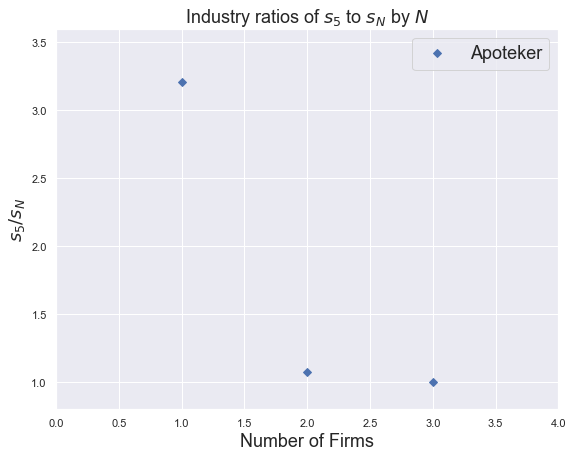

In [244]:
BIG = 18
fig = plt.figure(figsize=(9,7))
plt.plot([1,2,3], SN_S5_ratio, 'D', label='Apoteker')
ax = fig.get_axes()[0]
plt.legend(fontsize=BIG)
plt.xlim(0,4)
plt.ylim(0.8, 3.6)
plt.title('Industry ratios of $s_5$ to $s_N$ by $N$', fontsize=BIG)
plt.xlabel('Number of Firms', fontsize=BIG)
plt.ylabel('$s_5/s_N$', fontsize=BIG);
# ax.set_ylabel('$s_5/s_N$', fontsize=40)